In [1]:
#Import des packages nécessaires dans ce notebook
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
#Import puis lecture du jeu de données
df = pd.read_csv(r"C:\Users\Dylan\Desktop\Portfolio\MPG\MPG.csv")

df.head()

,Joueur,Poste,Cote,Enchère moy,Note,Note série,Note 1 an,Nb match,Nb match série,Nb match 1 an,...,Action stoppée,DMI,Club,Prochain opposant,Date,Victoire probable,%Win+12J,%Win+16J,%Win+20J,Ligue
0,Osimhen Victor,A,44,82.0,6.06,5.61,6.01,32,9,34,...,NaN,0,Napoli,NaN,NaN,NaN,NaN,NaN,NaN,SerieA
1,Martínez Lautaro,A,42,45.0,5.64,5.64,5.71,38,38,40,...,NaN,0,Inter,NaN,NaN,NaN,NaN,NaN,NaN,SerieA
2,Dia Boulaye,A,26,43.0,5.36,0.00,5.32,33,0,34,...,NaN,0,Salernitana,NaN,NaN,NaN,NaN,NaN,NaN,SerieA
3,Rafael Leão,A,34,72.0,5.83,7.00,5.92,35,3,37,...,NaN,0,Milan,NaN,NaN,NaN,NaN,NaN,NaN,SerieA
4,Lookman Ademola,A,26,NaN,5.66,5.17,5.61,31,3,32,...,NaN,0,Atalanta,NaN,NaN,NaN,NaN,NaN,NaN,SerieA


In [3]:
#Récupération des infos du DF pour observer les étapes de cleaning à réaliser
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2227 entries, 0 to 2226
Data columns (total 91 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Joueur             2227 non-null   object 
 1   Poste              2227 non-null   object 
 2   Cote               2227 non-null   int64  
 3   Enchère moy        1001 non-null   float64
 4   Note               2227 non-null   float64
 5   Note série         2227 non-null   float64
 6   Note 1 an          2227 non-null   float64
 7   Nb match           2227 non-null   int64  
 8   Nb match série     2227 non-null   int64  
 9   Nb match 1 an      2227 non-null   int64  
 10  Variation          2227 non-null   float64
 11  Var série          2227 non-null   float64
 12  Var 1 an           2227 non-null   float64
 13  But                2227 non-null   int64  
 14  Buts série         2227 non-null   int64  
 15  Buts 1 an          2227 non-null   int64  
 16  %Titu              2227 

In [4]:
#Recherche des NULL présents dans notre DF
df.isnull().sum()

Joueur                  0
Poste                   0
Cote                    0
Enchère moy          1226
Note                    0
                     ... 
Victoire probable    2227
%Win+12J             2227
%Win+16J             2227
%Win+20J             2227
Ligue                   0
Length: 91, dtype: int64

In [5]:
#Pour commencer, nous supprimons les joueurs ayant une note égale à 0 et ceux ayant joué moins de 15 matchs
#Ces joueurs ne sont pas significatifs, nous décidons d'alléger notre DF pour faciliter le machine learning à venir
df = df[df['Note']!=0]
df = df[df['Nb match']>14]

df.reset_index(drop=True, inplace=True)

In [6]:
#On crée une colonne Valeur_Joueur qui va prendre la valeur maximum entre Cote et Enchère moy. Puis on supprime Cote et Enchère moy

df['Valeur_Joueur'] = df[['Cote', 'Enchère moy']].max(axis=1)

df = df.drop(['Cote', 'Enchère moy'], axis=1)

In [7]:
#On remplit nos NA par 0 puis on vérifie s'il nous reste des NA
df['Min/But'] = df['Min/But'].fillna(0)
df['Pass decis.'] = df['Pass decis.'].fillna(0)
df['Occas° créée'] = df['Occas° créée'].fillna(0)
df['Corner gagné'] = df['Corner gagné'].fillna(0)
df['Cleansheet'] = df['Cleansheet'].fillna(0)
df['Interceptions'] = df['Interceptions'].fillna(0)
df['Tacles'] = df['Tacles'].fillna(0)
df['%Duel'] = df['%Duel'].fillna(0)
df['Fautes'] = df['Fautes'].fillna(0)
df['But évité'] = df['But évité'].fillna(0)
df['Action stoppée'] = df['Action stoppée'].fillna(0)
df['%Passes'] = df['%Passes'].fillna(0)
df['Ballons'] = df['Ballons'].fillna(0)

df.isna().sum()

Joueur              0
Poste               0
Note                0
Note série          0
Note 1 an           0
                 ... 
%Win+12J         1494
%Win+16J         1494
%Win+20J         1494
Ligue               0
Valeur_Joueur       0
Length: 90, dtype: int64

In [8]:
#On supprime les colonnes qui ne nous serviront pas/qui sont redondantes
colonnes_serie1an= df.filter(regex='série|1 an', axis=1)
colonnes_supprimees = ['Joueur', 'Club', 'Min/But', 'Min note/but', 'Prix/but','But/Peno', 'But/Coup-franc', 'But/surface', 'Prochain opposant', 'Date', 'Victoire probable', '%Win+12J', '%Win+16J', '%Win+20J', 'DMI']
df=df.drop(columns=colonnes_supprimees)
df=df.drop(columns=colonnes_serie1an)


In [9]:
#On classifie nos postes, ligues et notes pour nos ML de classification puis on va supprimer les colonnes Poste puis Ligue ainsi que Note car les données écrites peuvent causer des problèmes

poste_mapping = {
    'A':1,
    'MO':2,
    'MD':3,
    'DC':4,
    'DL':5,
    'G':6
}

ligue_mapping = {
    'SerieA': 1,
    'Ligue 1': 2,
    'Liga': 3,
    'Premier League': 4
}

intervalles = [0, 4.79, 4.99, 5.12, 5.27, 5.49, 10]
etiquettes = [1, 2, 3, 4, 5, 6]

df['Note_encoded'] = pd.cut(df['Note'], bins=intervalles, labels=etiquettes)
df['Poste_encoded']=df['Poste'].map(poste_mapping)
df['Ligue_encoded'] = df['Ligue'].map(ligue_mapping)

df=df.drop(['Poste'], axis=1)
df=df.drop(['Ligue'], axis=1)
df=df.drop(['Note'], axis=1)

In [10]:
#On récupère la valeur max/min/médiane de chaque joueur
Valeur_max = df[['j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'j7', 'j8', 'j9', 'j10', 'j11', 'j12', 'j13', 'j14', 'j15', 'j16', 'j17', 'j18', 'j19', 'j20', 'j21', 'j22', 'j23', 'j24', 'j25', 'j26', 'j27', 'j28', 'j29', 'j30', 'j31', 'j32', 'j33', 'j34', 'j35', 'j36', 'j37', 'j38']].max(axis=1)
Valeur_min = df[['j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'j7', 'j8', 'j9', 'j10', 'j11', 'j12', 'j13', 'j14', 'j15', 'j16', 'j17', 'j18', 'j19', 'j20', 'j21', 'j22', 'j23', 'j24', 'j25', 'j26', 'j27', 'j28', 'j29', 'j30', 'j31', 'j32', 'j33', 'j34', 'j35', 'j36', 'j37', 'j38']].replace(0, float('inf')).min(axis=1)
Valeur_mediane = df[['j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'j7', 'j8', 'j9', 'j10', 'j11', 'j12', 'j13', 'j14', 'j15', 'j16', 'j17', 'j18', 'j19', 'j20', 'j21', 'j22', 'j23', 'j24', 'j25', 'j26', 'j27', 'j28', 'j29', 'j30', 'j31', 'j32', 'j33', 'j34', 'j35', 'j36', 'j37', 'j38']].median(axis=1)

#On crée une colonne qui rajoute nos valeurs
df['Note_Max'] = Valeur_max
df['Note_Min_Sans_Zero'] = Valeur_min
df['Note_Mediane'] = Valeur_mediane
#On vérifie l'état de notre DF
df.head(10)

,Nb match,Variation,But,%Titu,Temps,Tps moy,j38,j37,j36,j35,...,Fautes,But évité,Action stoppée,Valeur_Joueur,Note_encoded,Poste_encoded,Ligue_encoded,Note_Max,Note_Min_Sans_Zero,Note_Mediane
0,32,1.38,26,0.94,2583,80.72,7.0,7.5,5.5,5.0,...,40.0,0.0,0.0,82.0,6,1,1,8.5,3.0,6.00
1,38,1.29,21,0.71,2576,67.79,4.5,8.0,4.5,6.5,...,46.0,0.0,0.0,45.0,6,1,1,8.0,3.5,5.75
2,33,1.39,16,0.82,2527,76.58,0.0,0.0,6.5,5.0,...,28.0,0.0,0.0,43.0,5,1,1,8.0,3.0,5.00
3,35,1.42,15,0.80,2430,69.43,8.0,5.0,8.0,0.0,...,20.0,0.0,0.0,72.0,6,1,1,8.0,3.5,5.25
4,31,1.17,13,0.65,1733,55.90,6.0,4.5,5.0,0.0,...,24.0,0.0,0.0,26.0,6,1,1,8.0,4.0,5.00
5,33,1.04,13,0.76,2147,65.06,6.0,6.5,8.0,4.5,...,38.0,0.0,0.0,19.0,4,1,1,8.0,3.5,5.00
6,31,1.40,13,0.94,2653,85.58,5.0,2.5,4.0,6.0,...,57.0,0.0,0.0,23.0,2,1,1,7.5,2.5,4.00
7,25,1.31,12,0.84,1751,70.04,6.0,0.0,0.0,0.0,...,10.0,0.0,0.0,64.0,6,1,1,8.0,4.0,5.00
8,34,1.28,12,0.88,2539,74.68,6.0,4.5,6.5,4.0,...,20.0,0.0,0.0,58.0,6,2,1,9.0,3.5,6.00
9,26,1.14,12,0.85,1872,72.00,5.5,7.0,6.5,7.0,...,33.0,0.0,0.0,42.0,6,1,1,8.0,3.5,5.00


In [11]:
#On supprime les colonnes j1 à j38
colonnes_a_supprimer = ['j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'j7', 'j8', 'j9', 'j10', 'j11', 'j12', 'j13', 'j14', 'j15', 'j16', 'j17', 'j18', 'j19', 'j20', 'j21', 'j22', 'j23', 'j24', 'j25', 'j26', 'j27', 'j28', 'j29', 'j30', 'j31', 'j32', 'j33', 'j34', 'j35', 'j36', 'j37', 'j38']

df.drop(columns=colonnes_a_supprimer, axis=1, inplace=True)

In [12]:
#Début de la régression logistique

In [13]:
#Division des données et entraînement du modèle

X=df.drop('Note_encoded', axis=1)
y = df['Note_encoded']
       
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [14]:
#Creation d'un StandardScaler puis transformation des données

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
#Creation du modèle de régression logistique

model = LogisticRegression()

In [16]:
#Entrainement du modèle sur les données train
model.fit(X_train_scaled, y_train)

c:\Users\Dylan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

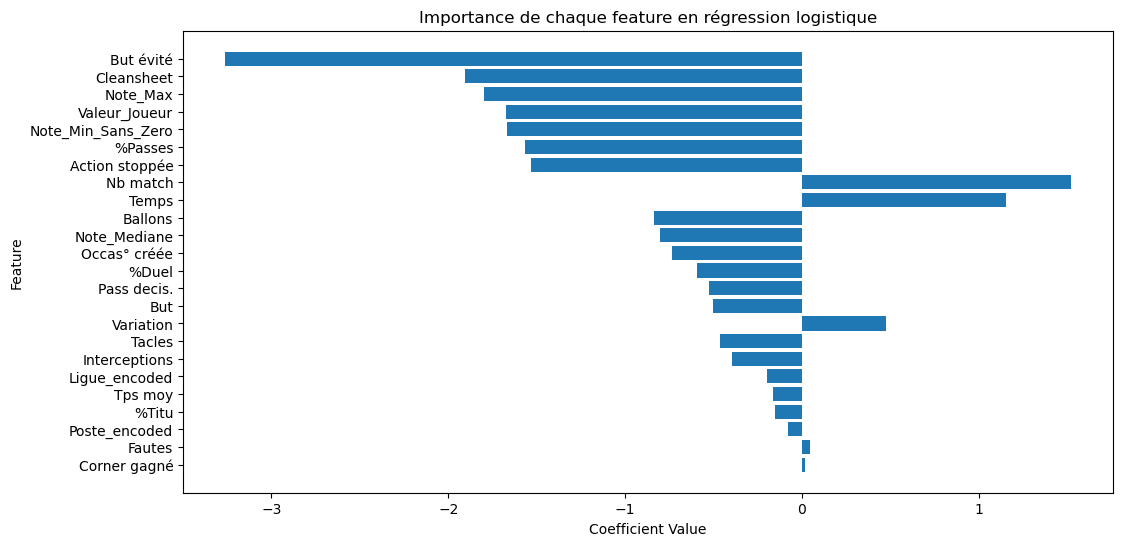

In [17]:
#Obtention des coefficients attribués à chaque caractéristique
coefficients = model.coef_[0]

#Association des coefficients aux noms des caractéristiques
feature_names = X.columns

#Création du DataFrame pour afficher les coefficients par caractéristique
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

#Tri des caractéristiques par coefficient absolu décroissant pour mettre en évidence les plus importantes
coefficients_df = coefficients_df.reindex(coefficients_df['Coefficient'].abs().sort_values(ascending=False).index)

#Affichage les coefficients dans un graphique trié par ordre décroissant
plt.figure(figsize=(12, 6))
plt.barh(coefficients_df['Feature'], coefficients_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Importance de chaque feature en régression logistique')
plt.gca().invert_yaxis()
plt.show()

In [18]:
#Print des scores

print('Score sur ensemble train', model.score(X_train, y_train))

print('Score sur ensemble test', model.score(X_test, y_test))

Score sur ensemble train 0.18571428571428572
Score sur ensemble test 0.20320855614973263


c:\Users\Dylan\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
c:\Users\Dylan\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


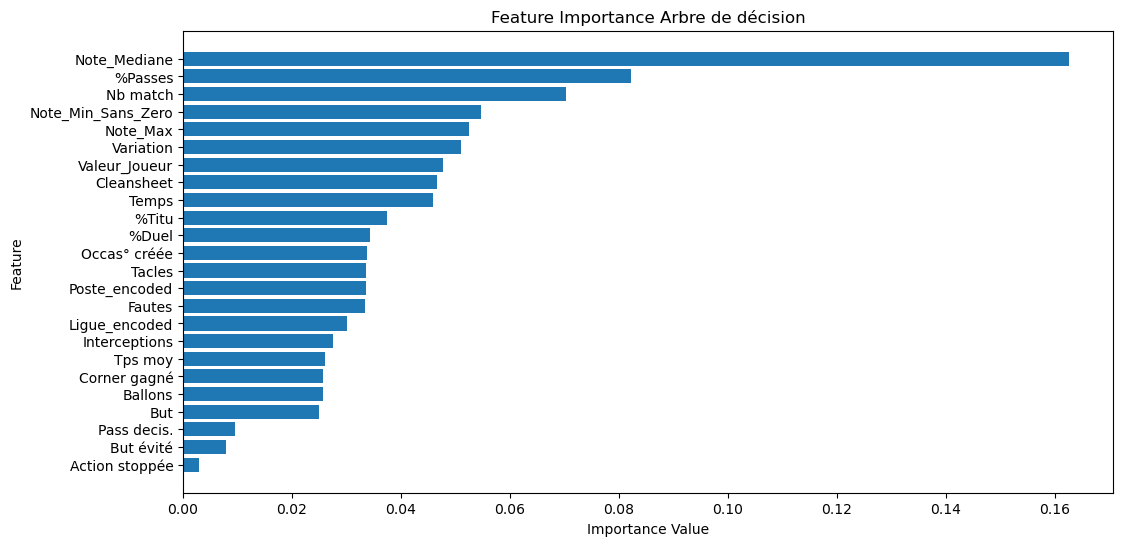

In [19]:
#Utilisation d'un arbre de décision pour comparer avec notre régression logistique. Affichage des feature importance dans un premier temps


X = df.drop('Note_encoded', axis=1)
y = df['Note_encoded']

#Entrainement du modèle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#Création du modèle d'arbre de décision
model = DecisionTreeClassifier()

#Entrainement du modèle sur les données d'entraînement
model.fit(X_train, y_train)

#Récupération de l'importance des caractéristiques
importances = model.feature_importances_

#Association des importances aux noms des caractéristiques
feature_names = X.columns

#Création d'un DataFrame pour afficher les importances par caractéristique
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

#Tri des caractéristiques par importance décroissante
importance_df = importance_df.sort_values(by='Importance', ascending=False)

#Affichage des importances dans un graphique
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance Value')
plt.ylabel('Feature')
plt.title('Feature Importance Arbre de décision')
plt.gca().invert_yaxis()
plt.show()

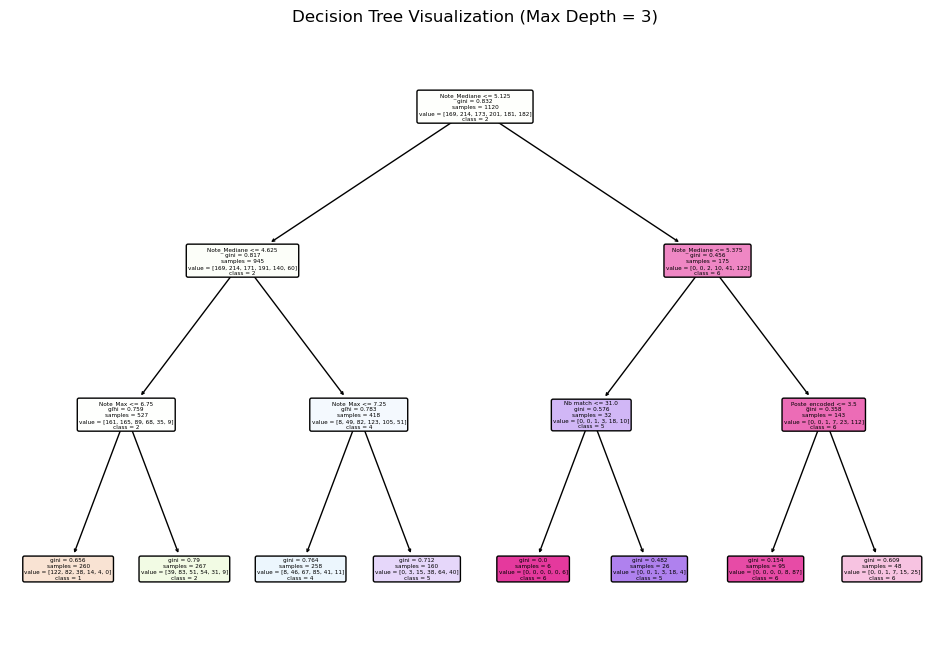

In [20]:
#Création d'un modèle d'arbre de décision limité à trois niveaux de profondeur
model = DecisionTreeClassifier(max_depth=3)

#Entrainement du modèle sur les données d'entraînement
model.fit(X_train, y_train)

#Affichage de l'arbre de décision
plt.figure(figsize=(12, 8))
plot_tree(model, feature_names=X.columns, class_names=list(map(str, model.classes_)), filled=True, rounded=True)
plt.title('Decision Tree Visualization (Max Depth = 3)')
plt.show()

In [21]:
print('Score sur ensemble train', model.score(X_train, y_train))

print('Score sur ensemble test', model.score(X_test, y_test))

Score sur ensemble train 0.4375
Score sur ensemble test 0.39037433155080214


In [22]:
#Génération des prédictions
y_pred = model.predict(X_test)

#Calcul des métriques de classification
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

#Affichage des métriques
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.39037433155080214
Precision: 0.36723341939113496
Recall: 0.39037433155080214
F1 Score: 0.3693335230530398


c:\Users\Dylan\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Export du DataFrame encodé

In [23]:
df.to_csv(r"C:\Users\Dylan\Desktop\Portfolio\MPG\MPG ENCODED.csv")